In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn
import sklearn.pipeline
import sklearn.neural_network
from sklearn import preprocessing

import calc_bal_acc

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


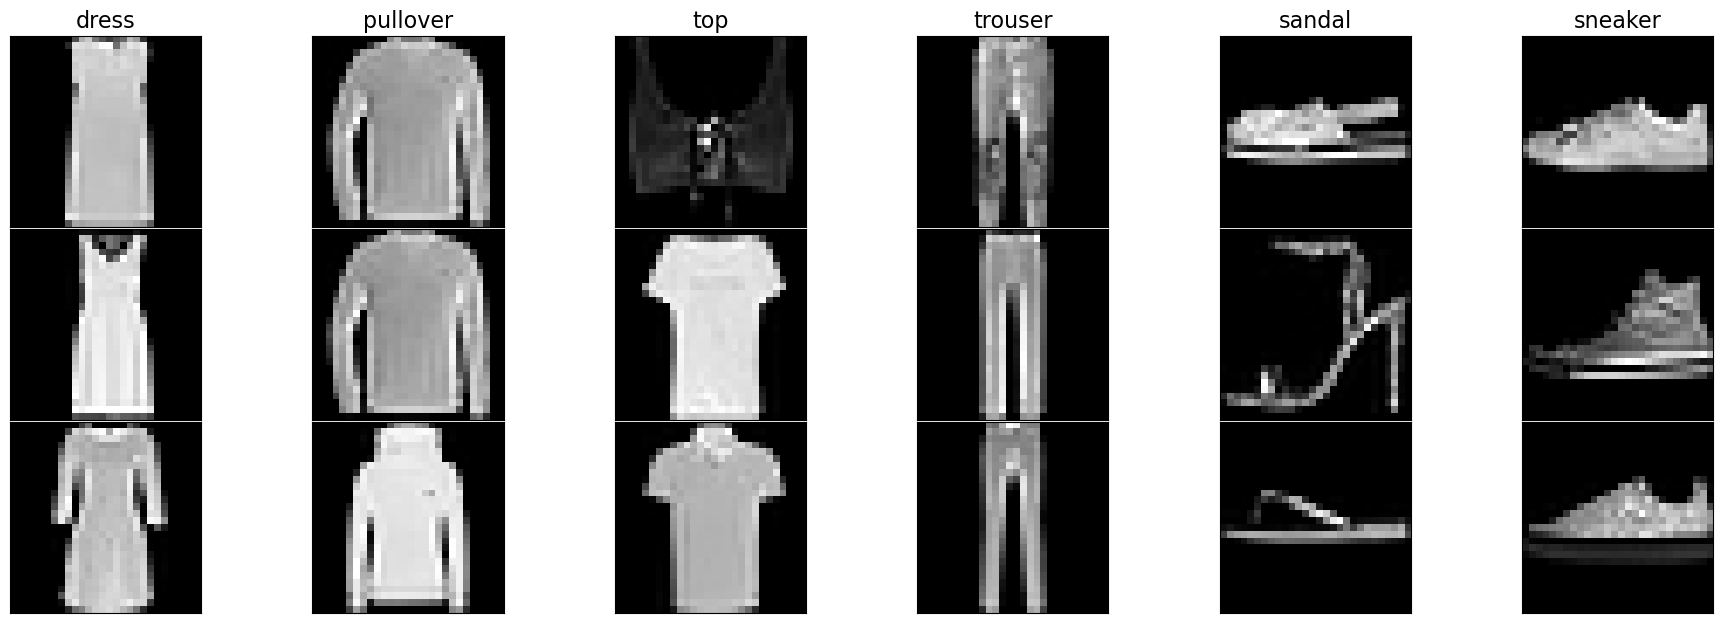

In [2]:
data_dir = os.path.abspath("data_fashion/")

# Load data
train_x = pd.read_csv(os.path.join(data_dir, "x_train.csv")).to_numpy()
train_y_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

valid_x = pd.read_csv(os.path.join(data_dir, "x_valid.csv")).to_numpy()
valid_y_df = pd.read_csv(os.path.join(data_dir, "y_valid.csv"))

test_x = pd.read_csv(os.path.join(data_dir, "x_test.csv")).to_numpy()

# Print shapes
for label, arr in [('train', train_x), ('valid', valid_x)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

# Display via a figure a few examples of each image class

prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();



In [3]:
pd.value_counts(np.array(train_y_df.loc[:,"class_name"]))

C:\Users\arman\AppData\Local\Temp\ipykernel_23152\1031658449.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(np.array(train_y_df.loc[:,"class_name"]))


sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
Name: count, dtype: int64

In [4]:
pd.value_counts(np.array(valid_y_df.loc[:,"class_name"]))

C:\Users\arman\AppData\Local\Temp\ipykernel_23152\2895670402.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(np.array(valid_y_df.loc[:,"class_name"]))


dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
Name: count, dtype: int64

In [5]:
y_train = train_y_df.loc[:,"class_uid"]
y_valid = valid_y_df.values[:,1].copy()



y_valid_df = valid_y_df.loc[:,"class_uid"]
y_valid_arr = valid_y_df.loc[:,"class_uid"].to_numpy()
y_train_arr = train_y_df.loc[:,"class_uid"].to_numpy()
#print(type(y_train))
#print(y_train.shape)
#print(type(y_valid_df))
#print(y_valid_df.shape)

labels = [0, 1]


idx = []

for n, values in enumerate(train_y_df['class_uid']):
    if values == 0:
        top = train_x[n]
        #print(n)
    if values == 1:
        trouser = train_x[n]
        #print(n)
tops = np.tile(top, (199, 1))
trousers = np.tile(trouser, (199, 1))

y_top = y_train.loc[np.repeat(1, 199)].reset_index(drop=True)
y_trouser = y_train.loc[np.repeat(11, 199)].reset_index(drop=True)




y_comb = np.hstack((y_train, y_top, y_trouser))
x_comb = np.concatenate((train_x, tops, trousers), axis=0)

print(x_comb.shape)
print(y_comb.shape)
#print(train_x.shape)
#print(y_train.shape)

(2500, 784)
(2500,)


In [16]:
def save_text(y_hat, file_name):
    names = ['top', 'trouser','pullover', 'dress','fifth','sandal','sixth','sneaker']
    

    # Load the dataset of interest
    datadir = os.path.abspath('data_fashion')
    x_NF = np.loadtxt(
        os.path.join(datadir, 'x_valid.csv'),
        delimiter=',',
        skiprows=1)
    N = x_NF.shape[0]

    # Create random predictions (just for fun)
    prng = np.random.RandomState(100)
    predictions = []
    for n in range(len(y_hat)):
        result = names[int(y_hat[n])]
        predictions.append(result)

    
    # Save the predictions in the leaderboard format
    np.savetxt(file_name, predictions, delimiter='\n', fmt='%s')

def pretty_print(y_valid, yhat):
    datadir = os.path.abspath('data_fashion')
    # Load true labels
    y_df = pd.read_csv(os.path.join(datadir, y_valid))
    ytrue_N = y_df['class_name'].values
    # Load predictions
    try:
        yhat_N = np.loadtxt(yhat, dtype=str)
    except IOError:
        raise ValueError("Did you run save_rand_predictions.py first??")
    assert ytrue_N.shape == yhat_N.shape
    #print("Loaded true and predicted labels")
    disp_df = pd.DataFrame(np.hstack([yhat_N[:,np.newaxis], ytrue_N[:,np.newaxis]]),
        columns=['yhat', 'ytrue'])
    #print(disp_df)
    
    bal_acc = sklearn.metrics.balanced_accuracy_score(ytrue_N, yhat_N)
    #accuracy = sklearn.metrics.accuracy_score(ytrue_N, yhat_N)
    
    print("Balanced Accuracy: %.3f" % bal_acc)
    print("")
    #print("Accuracy: %.3f" % accuracy)
    #print("remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = %.3f" % (1/6.))

In [7]:
valid_indicators_L = np.hstack([
    -1 * np.ones(y_train_arr.size), # -1 means never include this example in any test split
    0  * np.ones(y_valid_arr.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)



In [5]:
import time
start = time.time()

new_mlp = sklearn.pipeline.Pipeline([
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=0,
                                                           max_iter = 300,
                                                           alpha=0.001
                                                          )
    )
])

my_parameter_grid_by_name_embed = dict()
my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-3, 1, 5)
#my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 5)
#my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,256,256)]
#my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [300]
#my_parameter_grid_by_name_embed['my_classifier__solver'] = ['sgd', 'adam']
#my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu']
#my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    new_mlp,
    my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=3
)

grid_searcher_embed.fit(train_x, y_train)
#y_hat = grid_searcher_embed.predict(valid_x)

for param_name in sorted(my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\arman\.conda\envs\cs135_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [115]:
import time
start = time.time()

new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.0001,
                                                           early_stopping=True
                                                          )
    )
])

my_parameter_grid_by_name_embed = dict()
#my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    new_mlp,
    my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=3,
    refit=False
)

#grid_searcher_embed.fit(train_x, y_train)
grid_searcher_embed.fit(x_comb, y_comb)
#y_hat = grid_searcher_embed.predict(valid_x)

for param_name in sorted(my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
my_classifier__alpha: 1e-05
26.25293779373169


In [12]:
new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.0001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)
new_best_mlp.fit(x_comb, y_comb)
best_y_hat_valid = new_best_mlp.predict(valid_x)
best_y_hat_test = new_best_mlp.predict(test_x)

save_text(best_y_hat_valid, 'yhat_valid.txt')
save_text(best_y_hat_test, 'yhat_test.txt')
pretty_print('y_valid.csv','yhat_valid.txt')


Balanced Accuracy: 0.783

Accuracy: 0.783


(600,) (600,)


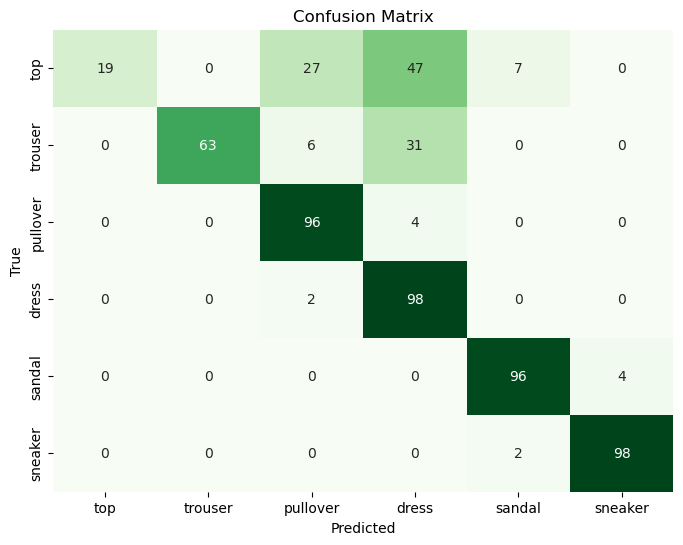

In [9]:


from sklearn.metrics import confusion_matrix
import seaborn as sns

print(y_valid.shape, best_y_hat_valid.shape)

conf_matrix = confusion_matrix(list(y_valid), list(best_y_hat_valid))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [19]:
for i in np.logspace(-5, 1, 7):
    new_best_mlp = sklearn.pipeline.Pipeline([
        ('max_abs_scaler', preprocessing.MinMaxScaler()),
        ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                               activation='relu',
                                                               solver='adam',
                                                               random_state=5,
                                                               max_iter = 300,
                                                               learning_rate_init=0.001,
                                                               alpha=i,
                                                               early_stopping=True,
                                                               warm_start=True
                                                               #learning_rate = 'adaptive'
                                                              )
        )
    ])
    
    new_best_mlp.fit(train_x, y_train)
    #new_best_mlp.fit(x_comb, y_comb)
    best_y_hat_valid = new_best_mlp.predict(valid_x)
    #best_y_hat_test = new_best_mlp.predict(test_x)
    save_text(best_y_hat_valid, 'yhat_valid.txt')
    
    print("Current alpha is: " + str(i))
    pretty_print('y_valid.csv','yhat_valid.txt')

Current alpha is: 1e-05
Balanced Accuracy: 0.648

Current alpha is: 0.0001
Balanced Accuracy: 0.648

Current alpha is: 0.001
Balanced Accuracy: 0.645

Current alpha is: 0.01
Balanced Accuracy: 0.642

Current alpha is: 0.1
Balanced Accuracy: 0.643

Current alpha is: 1.0
Balanced Accuracy: 0.643

Current alpha is: 10.0
Balanced Accuracy: 0.628



In [20]:
prob2_y_comb = np.hstack((y_train, y_valid))
prob2_x_comb = np.concatenate((train_x, valid_x), axis=0)

In [39]:
import time
start = time.time()

prob2_new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.0001,
                                                           early_stopping=True
                                                          )
    )
])

prob2_my_parameter_grid_by_name_embed = dict()
#prob2_my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
prob2_my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#prob2_my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#prob2_my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#prob2_my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#prob2_my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

prob2_grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    prob2_new_mlp,
    prob2_my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=3,
    refit=False
)

prob2_grid_searcher_embed.fit(train_x, y_train)
#prob2_grid_searcher_embed.fit(x_comb, y_comb)


gsearch_results_df_2 = pd.DataFrame(prob2_grid_searcher_embed.cv_results_).copy()
param_keys = ['param_my_classifier__alpha']
print(gsearch_results_df_2.round(3))
# Rearrange row order so it is easy to skim
gsearch_results_df_2.sort_values(param_keys, inplace=True)
var_2 = gsearch_results_df_2[param_keys + ['mean_test_score', 'rank_test_score']]
print(var_2)

for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, prob2_grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


C:\Users\arman\.conda\envs\cs135_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         16.129         4.908            0.065           0.005   
1         11.980         1.482            0.054           0.008   
2         13.141         1.943            0.050           0.006   
3         14.955         2.540            0.041           0.016   
4         13.358         1.976            0.037           0.014   
5         10.925         0.641            0.048           0.018   
6          7.117         0.898            0.023           0.008   

  param_my_classifier__alpha                            params  \
0                    0.00001   {'my_classifier__alpha': 1e-05}   
1                     0.0001  {'my_classifier__alpha': 0.0001}   
2                      0.001   {'my_classifier__alpha': 0.001}   
3                       0.01    {'my_classifier__alpha': 0.01}   
4                        0.1     {'my_classifier__alpha': 0.1}   
5                        1.0     {'my_classifier__alpha': 1.0}   
6

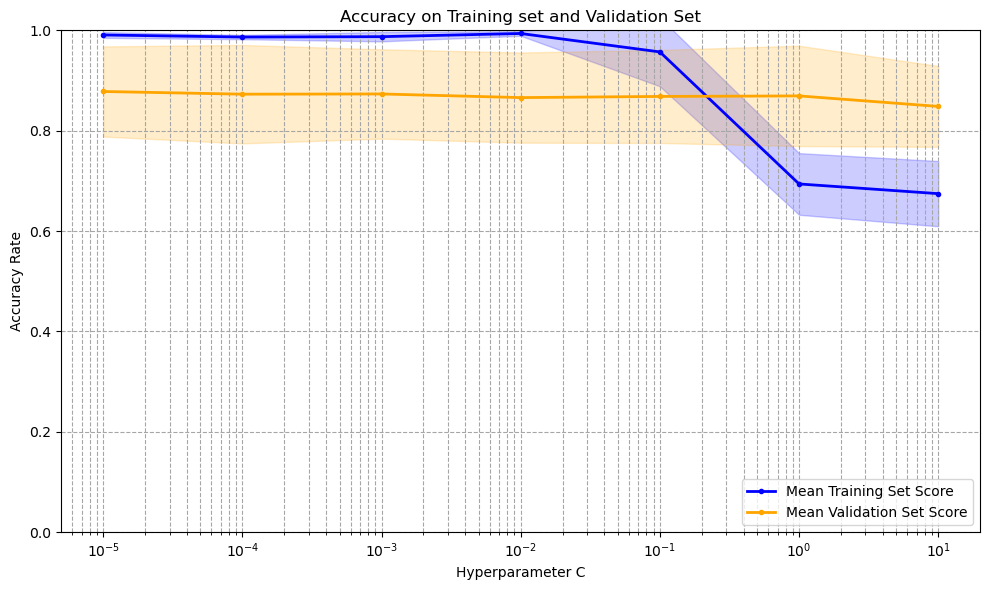

my_classifier__alpha: 1e-05


In [38]:
C_values = gsearch_results_df_2['param_my_classifier__alpha'].values.astype(float)
mean_train_score = gsearch_results_df_2['mean_train_score'].values
std_train_score = gsearch_results_df_2['std_train_score'].values
mean_test_scores = gsearch_results_df_2['mean_test_score'].values
std_test_scores = gsearch_results_df_2['std_test_score'].values

# Plotting
plt.figure(figsize=(10, 6))

# Training and validation mean scores
plt.plot(C_values, mean_train_score, '.-', color='blue', lw=2, label='Mean Training Set Score')
plt.plot(C_values, mean_test_scores, '.-', color='orange', lw=2, label='Mean Validation Set Score')

# Standard deviation range
plt.fill_between(C_values,
                 mean_train_score - std_train_score,
                 mean_train_score + std_train_score,
                 color='blue', alpha=0.2)
plt.fill_between(C_values,
                 mean_test_scores - std_test_scores,
                 mean_test_scores + std_test_scores,
                 color='orange', alpha=0.2)

plt.xscale("log")
plt.title("Accuracy on Training set and Validation Set")
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy Rate')
plt.legend(loc='lower right')
plt.ylim([0, 1])  # Assuming accuracy rate, range between 0 and 1
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

# Display best hyperparameters
for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print(f"{param_name}: {prob2_grid_searcher_embed.best_params_[param_name]}")
